In [3]:
from astro.load import Loader, GroupSessionData
from astro.preprocess import Preprocessor, GroupedEventPreprocessor
from astro.transforms import GroupSplitter

from astro.decoding_alltime import (
    ATDecodePreprocessor,
    latency_mask_factory,
    ModelFitterCV,
    ModelFitterFrac,
    all_time_decode_block,
    RunResults,
    ConfigTemplate,
    ATDConfig,
    generate_configuration,
    process_atd_config,
)
from astro.decoding_alltime.shuffle import make_shuffle_templates, replicate_template
from astro.decoding_alltime.config import create_configuration


from trace_minder.preprocess import TracePreprocessor
from trace_minder.align import GroupedAligner
from trace_minder.surrogates import SurrogateTemplate, Rotater, TraceSampler


from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import LeaveOneGroupOut


from dataclasses import dataclass
from typing import Generator, Callable
import pandas as pd
from astro.decoding_alltime.runner import RunResults
import numpy as np

import os
from pathlib import Path
from astro.config import Config

In [4]:
notebook_path = Path(os.getcwd())
root_path = notebook_path.parent.parent
env_path = root_path / ".env"

paths = Config.from_env(env_path)

### Common Params

In [29]:
loader = Loader(data_dir=paths.data_dir)

In [30]:
# loader preprocessors
#   - specifies how to preprocess traces and events upon loading

## loader preprocessor for first 5 trials
loader_preprocessor_first5 = Preprocessor(
    trace_preprocessor=TracePreprocessor(
        max_time=600,
        standardize=False,
        medfilt_kernel_size=None,
        resample_frequency=0.1,
    ),
    grouped_event_preprocessor=GroupedEventPreprocessor(
        df_events_group_col="mouse_name",
        df_events_event_time_col="start_time",
        first_x_events=5,
    ),
)


## loader preprocessor for last 5 trials
loader_preprocessor_last5 = Preprocessor(
    trace_preprocessor=TracePreprocessor(
        min_time=1200,
        standardize=False,
        medfilt_kernel_size=None,
        resample_frequency=0.1,
    ),
    grouped_event_preprocessor=GroupedEventPreprocessor(
        df_events_group_col="mouse_name",
        df_events_event_time_col="start_time",
        last_x_events=5,
    ),
)

In [31]:
# group splitter
#  - contains information needed to split traces by group/mouse

group_splitter = GroupSplitter(
    df_mice=loader.load_mice(),
    df_neurons=loader.load_neurons(),
    df_traces_time_col="time",
    # excluded_groups=["VEH-VEH"],
    df_neurons_mouse_col="mouse_name",
    df_mice_mouse_col="mouse_name",
    df_neurons_neuron_col="cell_id",
    df_mice_group_col="group",
)

### Tools for All Decoding

In [32]:
# initial aligner
#   - used to align traces to events

initial_aligner = GroupedAligner(
    t_before=30,
    t_after=30,
    df_wide_group_mapper=group_splitter.neurons_by_mouse(),
    df_events_event_time_col="start_time",
    df_events_group_col="mouse_name",
)

In [55]:
# adp preprocessor
#  - takes traces and events, aligns them, filters out specific latencies
#  - returns (df_temporal, df_aligned_traces, df_state)

atd_preprocessor_5sec = ATDecodePreprocessor(
    aligner=initial_aligner,
    latency_out_of_block=latency_mask_factory(-5, 0),
    latency_in_block=latency_mask_factory(0, 5),
)

In [56]:
# group_getter
#   - takes data produced by adp_preprocessor
#   - returns an array of groups (trials) for each row the three df


def group_getter(
    df_temporal: pd.DataFrame, df_aligned_traces: pd.DataFrame, df_state: pd.DataFrame
) -> np.ndarray:
    return df_temporal["event_idx"].values

In [57]:
# model


def model_factory() -> Pipeline:
    return Pipeline(
        [
            ("imputer", SimpleImputer()),
            ("scaler", StandardScaler()),
            (
                "logistic",
                LogisticRegression(solver="saga", max_iter=1000, C=0.1),
            ),
        ]
    )

In [58]:
# model fitter

model_fitter = ModelFitterCV(metric=f1_score, cv=LeaveOneGroupOut())

### Data Setup

In [59]:
run_templates = [
    ConfigTemplate(
        data_dir=paths.data_dir,
        session_name="ret",
        group="VEH-CNO",
        group_splitter=group_splitter,
        loader_preprocessor=loader_preprocessor_first5,
        block_group="CS",
        atd_preprocessor=atd_preprocessor_5sec,
        model_factory=model_factory,
        group_getter=group_getter,
        model_fitter=model_fitter,
    ),
    ConfigTemplate(
        data_dir=paths.data_dir,
        session_name="ret",
        group="CNO-VEH",
        group_splitter=group_splitter,
        loader_preprocessor=loader_preprocessor_first5,
        block_group="CS",
        atd_preprocessor=atd_preprocessor_5sec,
        model_factory=model_factory,
        group_getter=group_getter,
        model_fitter=model_fitter,
    ),
    ConfigTemplate(
        data_dir=paths.data_dir,
        session_name="ret",
        group="VEH-VEH",
        group_splitter=group_splitter,
        loader_preprocessor=loader_preprocessor_first5,
        block_group="CS",
        atd_preprocessor=atd_preprocessor_5sec,
        model_factory=model_factory,
        group_getter=group_getter,
        model_fitter=model_fitter,
    ),
    ConfigTemplate(
        data_dir=paths.data_dir,
        session_name="ext",
        group="VEH-CNO",
        group_splitter=group_splitter,
        loader_preprocessor=loader_preprocessor_first5,
        block_group="CS",
        atd_preprocessor=atd_preprocessor_5sec,
        model_factory=model_factory,
        group_getter=group_getter,
        model_fitter=model_fitter,
    ),
    ConfigTemplate(
        data_dir=paths.data_dir,
        session_name="ext",
        group="VEH-VEH",
        group_splitter=group_splitter,
        loader_preprocessor=loader_preprocessor_first5,
        block_group="CS",
        atd_preprocessor=atd_preprocessor_5sec,
        model_factory=model_factory,
        group_getter=group_getter,
        model_fitter=model_fitter,
    ),
    ConfigTemplate(
        data_dir=paths.data_dir,
        session_name="ext",
        group="CNO-VEH",
        group_splitter=group_splitter,
        loader_preprocessor=loader_preprocessor_first5,
        block_group="CS",
        atd_preprocessor=atd_preprocessor_5sec,
        model_factory=model_factory,
        group_getter=group_getter,
        model_fitter=model_fitter,
    ),
]

## Run templates

In [60]:
def mean_confint(x: np.ndarray) -> pd.Series:
    mean = np.mean(x)
    if len(x) == 1:
        return pd.Series([mean, np.nan, np.nan], index=["mean", "lower", "upper"])
    else:
        lower = np.quantile(x, 0.025)
        upper = np.quantile(x, 0.975)
        return pd.Series([mean, lower, upper], index=["mean", "lower", "upper"])

#### All Neurons, Single Time

In [61]:
@dataclass
class ResultsAllNeurons:
    session: str
    group: str
    model_desc: str
    score: str

    def to_dict(self) -> dict:
        return {
            "session": self.session,
            "group": self.group,
            "model_desc": self.model_desc,
            "score": self.score,
        }

In [62]:
@dataclass
class ResultsAllNeuronsSample:
    session: str
    group: str
    model_desc: str
    score: str
    sample: int

    def to_dict(self) -> dict:
        return {
            "session": self.session,
            "group": self.group,
            "model_desc": self.model_desc,
            "score": self.score,
            "sample": self.sample,
        }


run_res: list[ResultsAllNeurons] = []

surrogate_factory = lambda: SurrogateTemplate(
    sampler=TraceSampler(frac_retained=1, with_replacement=True)
)


for template in run_templates:
    print(template.session_name, template.group)
    surrogate_templates = make_shuffle_templates(
        template=surrogate_template,
        n=15,
        surrogate_factory=surrogate_factory,
    )
    for i, surrogate_template in enumerate(surrogate_templates):
        atd_config = create_configuration(surrogate_template)
        run_result = process_atd_config(atd_config)

        run_res.append(
            ResultsAllNeuronsSample(
                session=template.session_name,
                group=template.group,
                model_desc=str(run_result.clf),
                score=run_result.score,
                sample=i,
            )
        )


df_all_neurons = pd.DataFrame([r.to_dict() for r in run_res])
display(df_all_neurons)

ret VEH-CNO
ret CNO-VEH
ret VEH-VEH
ext VEH-CNO
ext VEH-VEH
ext CNO-VEH


,session,group,model_desc,score,sample
0,ret,VEH-CNO,"Pipeline(steps=[('imputer', SimpleImputer()), ...",1.000000,0
1,ret,VEH-CNO,"Pipeline(steps=[('imputer', SimpleImputer()), ...",0.952851,1
2,ret,VEH-CNO,"Pipeline(steps=[('imputer', SimpleImputer()), ...",0.995918,2
3,ret,VEH-CNO,"Pipeline(steps=[('imputer', SimpleImputer()), ...",0.989474,3
4,ret,VEH-CNO,"Pipeline(steps=[('imputer', SimpleImputer()), ...",1.000000,4
...,...,...,...,...,...
85,ext,CNO-VEH,"Pipeline(steps=[('imputer', SimpleImputer()), ...",0.901493,10
86,ext,CNO-VEH,"Pipeline(steps=[('imputer', SimpleImputer()), ...",1.000000,11
87,ext,CNO-VEH,"Pipeline(steps=[('imputer', SimpleImputer()), ...",1.000000,12
88,ext,CNO-VEH,"Pipeline(steps=[('imputer', SimpleImputer()), ...",0.995918,13


/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

<Axes: xlabel='session', ylabel='score'>

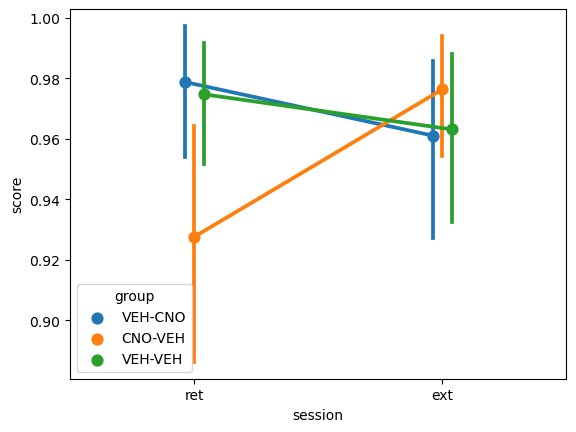

In [63]:
import seaborn as sns

sns.pointplot(
    data=df_all_neurons,
    x="session",
    y="score",
    hue="group",
    dodge=True,
)

#### All Neurons, Compared to Shuffle

In [18]:
@dataclass
class ResultsAllNeuronsShuffle(ResultsAllNeurons):
    shuffle: bool
    sample: int

    def to_dict(self) -> dict:
        d = super().to_dict()
        d["sample"] = self.sample
        d["shuffle"] = self.shuffle
        return d

In [19]:
N_SHUFFLES = 10
run_res: list[ResultsAllNeuronsShuffle] = []

surrogate_factory = lambda: SurrogateTemplate(
    rotater=Rotater(time_col="time", copy=True),
)

for template in run_templates:
    atd_config = create_configuration(template)
    run_result = process_atd_config(atd_config)

    run_res.append(
        ResultsAllNeuronsShuffle(
            session=template.session_name,
            group=template.group,
            model_desc=str(run_result.clf),
            score=run_result.score,
            sample=0,
            shuffle=False,
        )
    )

    surrogate_templates = make_shuffle_templates(
        template=template,
        n=N_SHUFFLES,
        surrogate_factory=surrogate_factory,
    )

    for i, surrogate_template in enumerate(surrogate_templates):
        atd_config = create_configuration(surrogate_template)
        run_result = process_atd_config(atd_config)

        run_res.append(
            ResultsAllNeuronsShuffle(
                session=template.session_name,
                group=template.group,
                model_desc=str(run_result.clf),
                score=run_result.score,
                sample=i,
                shuffle=True,
            )
        )

df_all_neurons_shuffle = pd.DataFrame([r.to_dict() for r in run_res])
display(
    df_all_neurons_shuffle.groupby(["session", "group", "shuffle"])["score"]
    .apply(mean_confint)
    .unstack()
)

mean     lower     upper
session group   shuffle                              
ext     CNO-VEH False    0.810618       NaN       NaN
                True     0.603441  0.267763  0.942812
        VEH-CNO False    1.000000       NaN       NaN
                True     0.641325  0.360340  0.987401
ret     CNO-VEH False    0.931353       NaN       NaN
                True     0.553204  0.185825  0.903484
        VEH-CNO False    1.000000       NaN       NaN
                True     0.645612  0.289870  0.879240

#### All Neurons, With Replacement

In [20]:
@dataclass
class ResultsAllNeuronsSampleWindow(ResultsAllNeurons):
    sample: int
    window_start: int
    window_end: int

    def to_dict(self) -> dict:
        d = super().to_dict()
        d["sample"] = self.sample
        d["window_start"] = self.window_start
        d["window_end"] = self.window_end
        return d

In [21]:
from copy import deepcopy

N_BOOT = 10
run_res: list[ResultsAllNeuronsSampleWindow] = []

surrogate_factory = lambda: SurrogateTemplate(
    sampler=TraceSampler(frac_retained=1, with_replacement=True)
)

windows = [
    (0, 5),
    (5, 10),
    (10, 15),
    (15, 20),
]

for template in run_templates:
    for window in windows:
        template_window = deepcopy(template)
        template.atd_preprocessor.latency_in_block = latency_mask_factory(*window)
        surrogate_templates = make_shuffle_templates(
            template=template_window,
            n=N_BOOT,
            surrogate_factory=surrogate_factory,
        )
        for i, surrogate_template in enumerate(surrogate_templates):
            atd_config = create_configuration(surrogate_template)
            run_result = process_atd_config(atd_config)

            run_res.append(
                ResultsAllNeuronsSampleWindow(
                    session=template_window.session_name,
                    group=template_window.group,
                    model_desc=str(run_result.clf),
                    score=run_result.score,
                    sample=i,
                    window_start=window[0],
                    window_end=window[1],
                )
            )

df_all_neurons_sample = pd.DataFrame([r.to_dict() for r in run_res])
# display(
#     df_all_neurons_sample.groupby(["session", "group"])["score"]
#     .apply(mean_confint)
#     .unstack()
# )

In [22]:
df_all_neurons_sample

,session,group,model_desc,score,sample,window_start,window_end
0,ret,VEH-CNO,"Pipeline(steps=[('imputer', SimpleImputer()), ...",1.000000,0,0,5
1,ret,VEH-CNO,"Pipeline(steps=[('imputer', SimpleImputer()), ...",1.000000,1,0,5
2,ret,VEH-CNO,"Pipeline(steps=[('imputer', SimpleImputer()), ...",1.000000,2,0,5
3,ret,VEH-CNO,"Pipeline(steps=[('imputer', SimpleImputer()), ...",1.000000,3,0,5
4,ret,VEH-CNO,"Pipeline(steps=[('imputer', SimpleImputer()), ...",0.997980,4,0,5
...,...,...,...,...,...,...,...
155,ext,CNO-VEH,"Pipeline(steps=[('imputer', SimpleImputer()), ...",0.871474,5,15,20
156,ext,CNO-VEH,"Pipeline(steps=[('imputer', SimpleImputer()), ...",0.970115,6,15,20
157,ext,CNO-VEH,"Pipeline(steps=[('imputer', SimpleImputer()), ...",0.833974,7,15,20
158,ext,CNO-VEH,"Pipeline(steps=[('imputer', SimpleImputer()), ...",0.746351,8,15,20


/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

Text(0.5, 1.0, 'Retrieval')

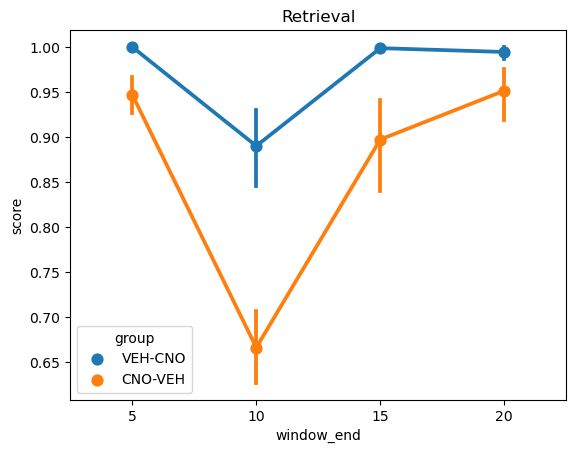

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt


f, ax = plt.subplots()


(
    df_all_neurons_sample.query("session == 'ret'").pipe(
        lambda x: sns.pointplot(data=x, x="window_end", y="score", hue="group", ax=ax)
    )
)

ax.set_title("Retrieval")

/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

Text(0.5, 1.0, 'Extinction')

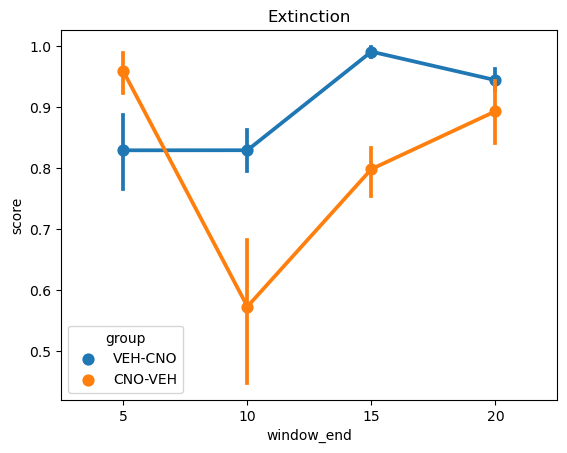

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt


f, ax = plt.subplots()


(
    df_all_neurons_sample.query("session == 'ext'").pipe(
        lambda x: sns.pointplot(data=x, x="window_end", y="score", hue="group", ax=ax)
    )
)

ax.set_title("Extinction")

In [26]:
outpath = paths.derived_data_dir / "atd_decoding"
outpath.mkdir(exist_ok=True)

df_all_neurons_sample.to_csv(outpath / "logreg-all_neurons_window.csv", index=False)

## Variable Number of Neurons

In [27]:
@dataclass
class ResultsLimitedNeurons(ResultsAllNeurons):
    n_neurons: int
    sample: int
    shuffle: bool

    def to_dict(self) -> dict:
        d = super().to_dict()
        d["sample"] = self.sample
        d["n_neurons"] = self.n_neurons
        d["shuffle"] = self.shuffle
        return d

In [28]:
from tqdm import tqdm

N_PERMS = 2  # number of permutations per number of neurons
NEURON_MAX = 30  # max number of neurons to include a permutation

run_res: list[ResultsLimitedNeurons] = []


def surrogate_factory(
    n_neurons: int, rotate: bool = False
) -> Callable[[], SurrogateTemplate]:
    match rotate:
        case True:
            rotater = Rotater(time_col="time", copy=True)
        case False:
            rotater = None

    return lambda: SurrogateTemplate(
        sampler=TraceSampler(n_retained=n_neurons, with_replacement=True),
        rotater=rotater,
    )


for template in tqdm(run_templates):
    for rotate in [False]:
        for n_neurons in range(1, NEURON_MAX + 1):
            surrogate_templates = make_shuffle_templates(
                template,
                n=N_PERMS,
                surrogate_factory=surrogate_factory(n_neurons, rotate=rotate),
            )
            for sample_idx, surrogate_template in enumerate(surrogate_templates):
                try:
                    atd_config = create_configuration(surrogate_template)
                    run_result = process_atd_config(atd_config)
                    run_res.append(
                        ResultsLimitedNeurons(
                            session=template.session_name,
                            group=template.group,
                            model_desc=str(run_result.clf),
                            score=run_result.score,
                            n_neurons=n_neurons,
                            sample=sample_idx,
                            shuffle=rotate,
                        )
                    )
                except:
                    print(
                        f"Error on session={template.session_name}, group={template.group}, n_neurons={n_neurons}, sample={sample_idx} rotation={rotate}"
                    )
                    continue


df_limit_neurons_shuffle = pd.DataFrame([r.to_dict() for r in run_res])

100%|██████████| 4/4 [01:09<00:00, 17.35s/it]


In [40]:
outpath = paths.derived_data_dir / "atd_decoding"
outpath.mkdir(exist_ok=True)

df_limit_neurons_shuffle.to_csv(
    outpath / "df_limit_neurons_shuffle_ext_ret.csv", index=False
)

/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

Text(0.5, 1.0, 'Retrieval')

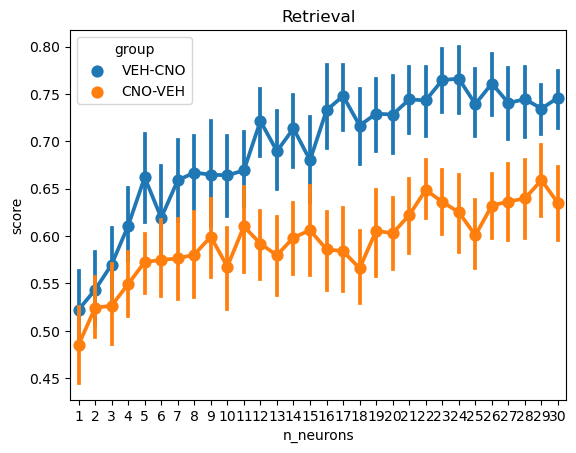

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt


f, ax = plt.subplots()


(
    df_limit_neurons_shuffle.query("session == 'ret' and shuffle==False").pipe(
        lambda x: sns.pointplot(data=x, x="n_neurons", y="score", hue="group", ax=ax)
    )
)

ax.set_title("Retrieval")

/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

Text(0.5, 1.0, 'Extinction')

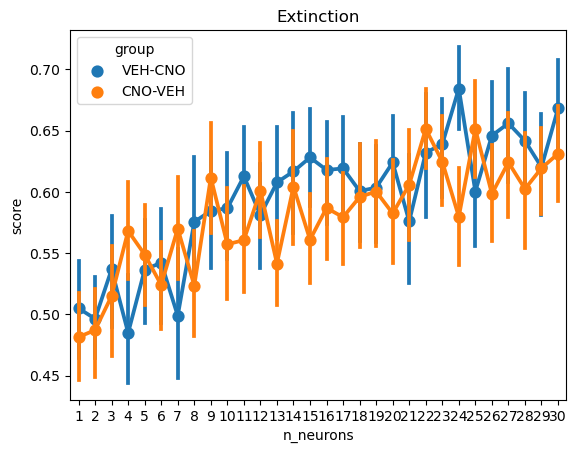

In [44]:
f, ax = plt.subplots()


(
    df_limit_neurons_shuffle.query("session == 'ext' and shuffle==False").pipe(
        lambda x: sns.pointplot(data=x, x="n_neurons", y="score", hue="group", ax=ax)
    )
)

ax.set_title("Extinction")

## Variable Number of PCs

In [17]:
from sklearn.decomposition import PCA


@dataclass
class ResultsLimitedPCs(ResultsAllNeurons):
    n_pcs: int
    shuffle: bool
    sample: int = None
    total_var_retained: float = None
    var_per_comp: np.ndarray = None

    def to_dict(self) -> dict:
        d = super().to_dict()
        d["sample"] = self.sample
        d["n_pcs"] = self.n_pcs
        d["shuffle"] = self.shuffle
        d["total_var_retained"] = self.total_var_retained
        d["var_per_comp"] = self.var_per_comp

        return d


def model_factory_maker(num_pcs: int) -> Callable[[], Pipeline]:
    return lambda: Pipeline(
        [
            ("imputer", SimpleImputer()),
            ("scaler", StandardScaler()),
            ("pca", PCA(n_components=num_pcs)),
            (
                "logistic",
                LogisticRegression(solver="saga", max_iter=1000, C=0.1),
            ),
        ]
    )

In [19]:
from tqdm import tqdm

PCS_MAX = 30  # max number of neurons to include a permutation
N_PERMS = 40  # number of permutations per number of neurons

run_res: list[ResultsLimitedPCs] = []


def surrogate_factory(rotate: bool = False) -> Callable[[], SurrogateTemplate] | None:
    match rotate:
        case True:
            return lambda: SurrogateTemplate(
                rotater=Rotater(time_col="time", copy=True)
            )
        case False:
            return None


for template in tqdm(run_templates):
    for rotate in [True, False]:
        for n_components in range(1, PCS_MAX + 1):
            surrogate_template = make_shuffle_templates(
                template,
                n=40,
                surrogate_factory=surrogate_factory(rotate=rotate),
            )[0]
            surrogate_template.model_factory = model_factory_maker(n_components)

            atd_config = create_configuration(surrogate_template)
            run_result = process_atd_config(atd_config)
            fitted_pipe = run_result.clf
            pca = fitted_pipe.named_steps["pca"]
            total_var = np.sum(pca.explained_variance_ratio_) * 100
            var_per_comp = pca.explained_variance_ratio_ * 100
            run_res.append(
                ResultsLimitedPCs(
                    session=template.session_name,
                    group=template.group,
                    model_desc=str(run_result.clf),
                    score=run_result.score,
                    n_pcs=n_components,
                    total_var_retained=total_var,
                    var_per_comp=var_per_comp,
                    shuffle=rotate,
                )
            )


df_limit_pcs_shuffle = pd.DataFrame([r.to_dict() for r in run_res])

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [10:47<00:00, 161.90s/it]


/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

Text(0.5, 1.0, 'Retrieval')

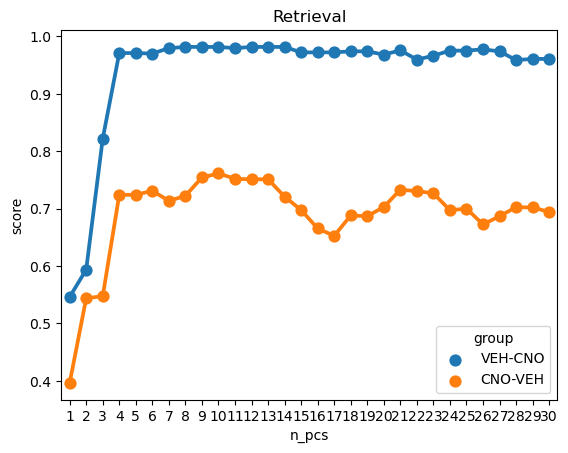

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots()


(
    df_limit_pcs_shuffle.query("session == 'ret' and shuffle==False").pipe(
        lambda x: sns.pointplot(data=x, x="n_pcs", y="score", hue="group", ax=ax)
    )
)

ax.set_title("Retrieval")

/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

Text(0.5, 1.0, 'Extinction')

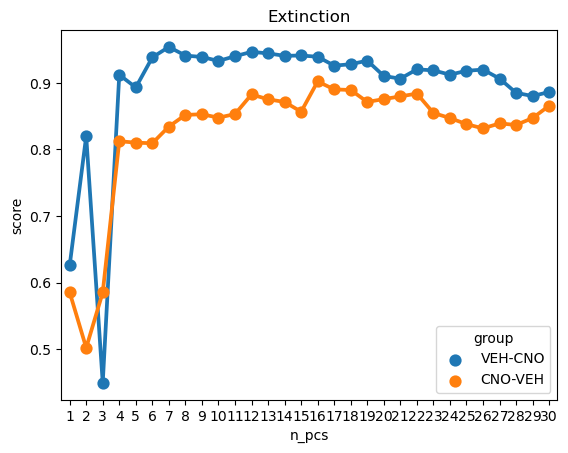

In [25]:
f, ax = plt.subplots()


(
    df_limit_pcs_shuffle.query("session == 'ext' and shuffle==False").pipe(
        lambda x: sns.pointplot(data=x, x="n_pcs", y="score", hue="group", ax=ax)
    )
)

ax.set_title("Extinction")

/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

Text(0.5, 1.0, 'Extinction')

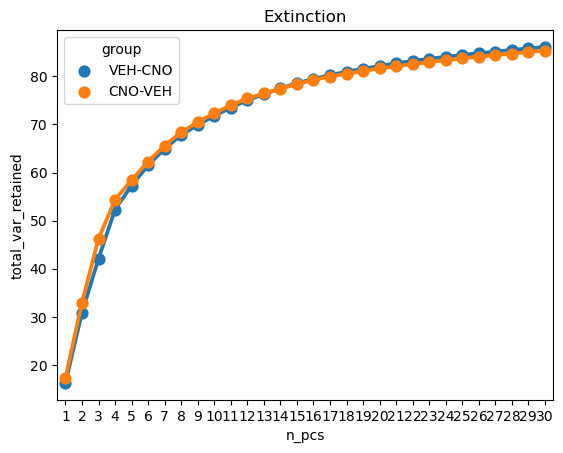

In [24]:
f, ax = plt.subplots()


(
    df_limit_pcs_shuffle.query("session == 'ret' and shuffle==False").pipe(
        lambda x: sns.pointplot(
            data=x, x="n_pcs", y="total_var_retained", hue="group", ax=ax
        )
    )
)

In [27]:
from tqdm import tqdm

PCS_MAX = 20  # max number of neurons to include a permutation
N_PERMS = 10  # number of permutations per number of neurons

run_res: list[ResultsLimitedPCs] = []


def surrogate_factory(rotate: bool = False) -> Callable[[], SurrogateTemplate] | None:
    match rotate:
        case True:
            rotator = Rotater(time_col="time", copy=True)
        case False:
            rotator = None

    return lambda: SurrogateTemplate(
        rotater=rotator,
        sampler=TraceSampler(frac_retained=1, with_replacement=True),
    )


for template in tqdm(run_templates):
    for rotate in [True, False]:
        for n_components in range(1, PCS_MAX + 1):
            surrogate_templates = make_shuffle_templates(
                template,
                n=N_PERMS,
                surrogate_factory=surrogate_factory(rotate=rotate),
            )
            for i, surrogate_template in enumerate(surrogate_templates):
                surrogate_template.model_factory = model_factory_maker(n_components)

                atd_config = create_configuration(surrogate_template)
                run_result = process_atd_config(atd_config)
                fitted_pipe = run_result.clf
                pca = fitted_pipe.named_steps["pca"]
                total_var = np.sum(pca.explained_variance_ratio_) * 100
                var_per_comp = pca.explained_variance_ratio_ * 100
                run_res.append(
                    ResultsLimitedPCs(
                        session=template.session_name,
                        group=template.group,
                        model_desc=str(run_result.clf),
                        score=run_result.score,
                        n_pcs=n_components,
                        total_var_retained=total_var,
                        var_per_comp=var_per_comp,
                        shuffle=rotate,
                        sample=i,
                    )
                )


df_limit_pcs_shuffle = pd.DataFrame([r.to_dict() for r in run_res])

100%|██████████| 4/4 [38:16<00:00, 574.10s/it]


In [28]:
outpath = paths.derived_data_dir / "atd_decoding"

outpath.mkdir(exist_ok=True)

df_limit_pcs_shuffle.to_csv(
    outpath / "df_limit_pcs_shuffle_resample_ext_ret.csv", index=False
)

/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

<Axes: xlabel='n_pcs', ylabel='total_var_retained'>

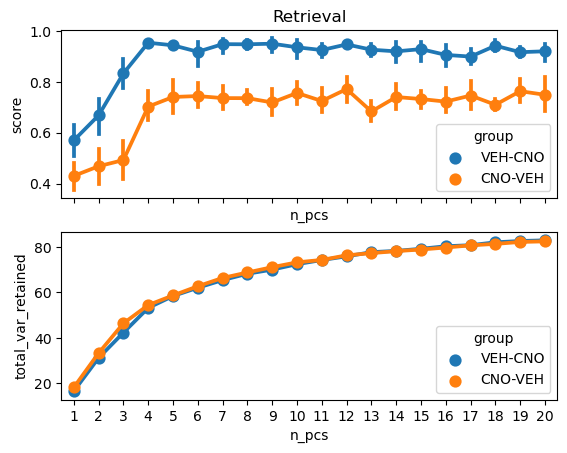

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(nrows=2, sharex=True)


(
    df_limit_pcs_shuffle.query("session == 'ret' and shuffle==False").pipe(
        lambda x: sns.pointplot(data=x, x="n_pcs", y="score", hue="group", ax=ax[0])
    )
)

ax[0].set_title("Retrieval")


(
    df_limit_pcs_shuffle.query("session == 'ret' and shuffle==False").pipe(
        lambda x: sns.pointplot(
            data=x, x="n_pcs", y="total_var_retained", hue="group", ax=ax[1]
        )
    )
)

# ax[].set_title("Retrieval")

/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

<Axes: xlabel='n_pcs', ylabel='total_var_retained'>

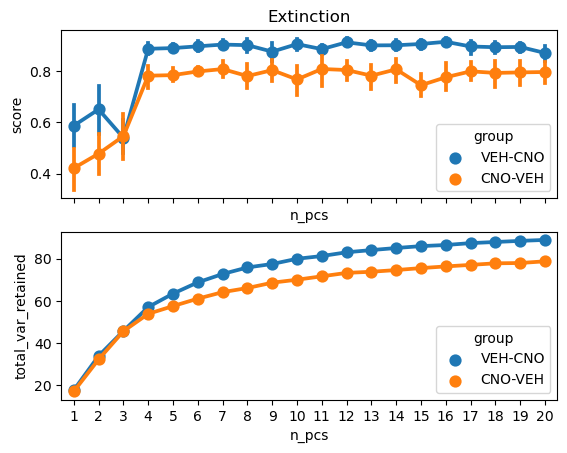

In [33]:
f, ax = plt.subplots(nrows=2, sharex=True)


(
    df_limit_pcs_shuffle.query("session == 'ext' and shuffle==False").pipe(
        lambda x: sns.pointplot(data=x, x="n_pcs", y="score", hue="group", ax=ax[0])
    )
)

ax[0].set_title("Extinction")


(
    df_limit_pcs_shuffle.query("session == 'ext' and shuffle==False").pipe(
        lambda x: sns.pointplot(
            data=x, x="n_pcs", y="total_var_retained", hue="group", ax=ax[1]
        )
    )
)